LHS: Generated 50 initial guesses for 2-dimensional space
Attempting multi-start fit with 50 trials for model: logistic_model
LHS: Generated 50 initial guesses for 3-dimensional space
Attempting multi-start fit with 50 trials for model: gompertz_model
LHS: Generated 50 initial guesses for 5-dimensional space
Attempting multi-start fit with 50 trials for model: richards_model
LHS: Generated 50 initial guesses for 4-dimensional space
Attempting multi-start fit with 50 trials for model: ltvlms_model


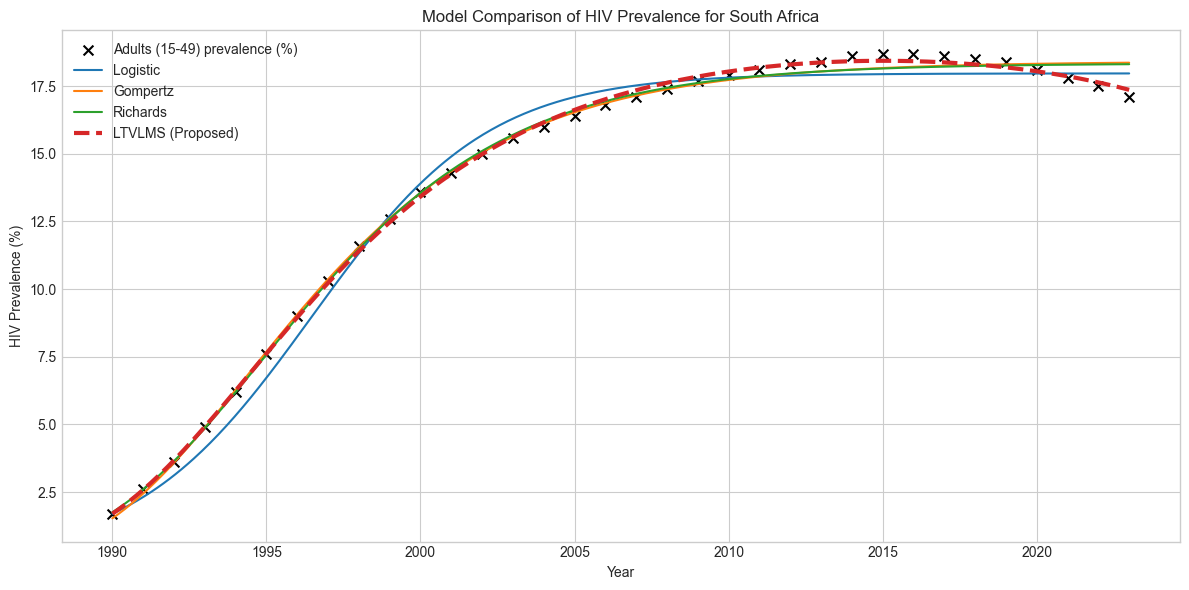

LHS: Generated 20 initial guesses for 2-dimensional space
Attempting multi-start fit with 20 trials for model: logistic_model
LHS: Generated 20 initial guesses for 2-dimensional space
Attempting multi-start fit with 20 trials for model: logistic_model
LHS: Generated 20 initial guesses for 2-dimensional space
Attempting multi-start fit with 20 trials for model: logistic_model
LHS: Generated 20 initial guesses for 2-dimensional space
Attempting multi-start fit with 20 trials for model: logistic_model
LHS: Generated 20 initial guesses for 2-dimensional space
Attempting multi-start fit with 20 trials for model: logistic_model
LHS: Generated 20 initial guesses for 3-dimensional space
Attempting multi-start fit with 20 trials for model: gompertz_model
LHS: Generated 20 initial guesses for 3-dimensional space
Attempting multi-start fit with 20 trials for model: gompertz_model
LHS: Generated 20 initial guesses for 3-dimensional space
Attempting multi-start fit with 20 trials for model: gompert

,RMSE,R2,AIC,BIC,Adj-AIC,Adj-BIC,CV-MSE
Logistic,0.551171,0.988816,-36.508248,-33.455527,-36.121152,-33.261979,0.352684
Gompertz,0.346687,0.995575,-66.034618,-61.455536,-65.234618,-61.055536,0.154037
Richards,0.338693,0.995777,-63.620861,-55.989058,-61.478003,-54.917629,0.149344
LTVLMS,0.153089,0.999137,-119.618214,-113.512772,-118.238904,-112.823117,0.027541


,K,r,t0,alpha,nu,r0,r1
Logistic,17.970626,0.348892,NaN,NaN,NaN,NaN,NaN
Gompertz,18.411425,0.209346,4.353687,NaN,NaN,NaN,NaN
Richards,18.340987,0.226794,2.439643,0.35296,0.203863,NaN,NaN
LTVLMS,21.941421,NaN,NaN,NaN,0.238760,1.0,-0.039958


In [1]:
###** Redouane Betrouni & Kernane Tewfik codes **##
## UNAIDS South Africa 1990-2023 HIV Prevalence Estimates Curve Fitting. 

# --- Cell 1: Imports and Setup ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from pyDOE import lhs
import warnings
import os

# For consistent results
np.random.seed(42)
warnings.filterwarnings("ignore")
os.makedirs("plots", exist_ok=True)


# --- Cell 2: Load UNAIDS South Africa Data ---
years = np.arange(1990, 2024)
prevalence = np.array([
    1.7, 2.6, 3.6, 4.9, 6.2, 7.6, 9.0, 10.3, 11.6, 12.6,
    13.6, 14.3, 15.0, 15.6, 16.0, 16.4, 16.8, 17.1, 17.4,
    17.7, 17.9, 18.1, 18.3, 18.4, 18.6, 18.7, 18.7, 18.6,
    18.5, 18.4, 18.1, 17.8, 17.5, 17.1
])
t = years - 1990


# --- Cell 3: Model Definitions ---
def logistic_model(t, K, r):
    y0 = prevalence[0]
    return K / (1 + ((K - y0) / y0) * np.exp(-r * t))

def gompertz_model(t, K, r, t0):
    return K * np.exp(-np.exp(-r * (t - t0)))

def richards_model(t, K, r, t0, alpha, nu):
    return K / ((1 + alpha * np.exp(-r * (t - t0)))**(1 / nu))

def ltvlms_model(t, K, r0, r1, nu):
    y0 = prevalence[0]
    expo_term = -nu * (r0 * t + 0.5 * r1 * t**2)
    inner_bracket = 1 + ((K**nu - y0**nu) / y0**nu) * np.exp(expo_term)
    return K / (inner_bracket**(1 / nu))


# --- Cell 4: Metric Functions ---
def compute_metrics(y_true, y_pred, k):
    n = len(y_true)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    aic = n * np.log(mse) + 2 * k
    bic = n * np.log(mse) + k * np.log(n)
    adj_aic = aic + (2 * k * (k + 1)) / (n - k - 1)
    adj_bic = bic + (k * (k + 1)) / (n - k - 1)
    return rmse, r2, aic, bic, adj_aic, adj_bic


# --- Cell 5: Latin Hypercube Sampling Utility ---
def latin_hypercube_init(bounds, n_samples=50):
    dim = len(bounds)
    lhs_samples = lhs(dim, samples=n_samples)
    scaled = np.array([
        bounds[i][0] + (bounds[i][1] - bounds[i][0]) * lhs_samples[:, i]
        for i in range(dim)
    ]).T
    print(f"LHS: Generated {n_samples} initial guesses for {dim}-dimensional space")
    return scaled


# --- Cell 6: Multi-start Curve Fitting ---
def multi_start_fit(model_func, t, y, bounds, n_starts=50):
    best_score = np.inf
    best_params = None
    init_guesses = latin_hypercube_init(bounds, n_samples=n_starts)
    print(f"Attempting multi-start fit with {n_starts} trials for model: {model_func.__name__}")
    for guess in init_guesses:
        try:
            params, _ = curve_fit(model_func, t, y, p0=guess, bounds=np.array(bounds).T, maxfev=100000)
            pred = model_func(t, *params)
            score = mean_squared_error(y, pred)
            if score < best_score:
                best_score = score
                best_params = params
        except:
            continue
    return best_params


# --- Cell 7: Parameter Bounds ---
y0 = prevalence[0]
K_bounds = [0.5 * max(prevalence), 2 * max(prevalence)]
r_bounds = [0.0001, 1.0]
t0_bounds = [0, t[-1]]
alpha_bounds = [0.001, 10]
nu_bounds = [0.01, 10]
r1_bounds = [-1, 0]

bounds_logistic = [K_bounds, r_bounds]
bounds_gompertz = [K_bounds, r_bounds, t0_bounds]
bounds_richards = [K_bounds, r_bounds, t0_bounds, alpha_bounds, nu_bounds]
bounds_ltvlms = [K_bounds, r_bounds, r1_bounds, nu_bounds]


# --- Cell 8: Fit All Models ---
params_logistic = multi_start_fit(logistic_model, t, prevalence, bounds_logistic)
params_gompertz = multi_start_fit(gompertz_model, t, prevalence, bounds_gompertz)
params_richards = multi_start_fit(richards_model, t, prevalence, bounds_richards)
params_ltvlms = multi_start_fit(ltvlms_model, t, prevalence, bounds_ltvlms)


# --- Cell 9: Evaluate and Compare ---
preds = {
    "Logistic": logistic_model(t, *params_logistic),
    "Gompertz": gompertz_model(t, *params_gompertz),
    "Richards": richards_model(t, *params_richards),
    "LTVLMS": ltvlms_model(t, *params_ltvlms)
}

results = {}
for name, y_hat in preds.items():
    k = len(eval(f"params_{name.lower()}"))
    results[name] = compute_metrics(prevalence, y_hat, k)

metrics_df = pd.DataFrame(results, index=["RMSE", "R2", "AIC", "BIC", "Adj-AIC", "Adj-BIC"]).T
param_df = pd.DataFrame({
    "Logistic": pd.Series(params_logistic),
    "Gompertz": pd.Series(params_gompertz),
    "Richards": pd.Series(params_richards),
    "LTVLMS": pd.Series(params_ltvlms)
}).T

metrics_df, param_df


# --- Cell 10: Plotting ---
plt.style.use('seaborn-v0_8-whitegrid')
t_fine = np.linspace(t[0], t[-1], 500)
years_fine = t_fine + 1990

plt.figure(figsize=(12, 6))
plt.scatter(years, prevalence, label='Adults (15-49) prevalence (%)', color='black', s=50, marker='x')
plt.plot(years_fine, logistic_model(t_fine, *params_logistic), label='Logistic')
plt.plot(years_fine, gompertz_model(t_fine, *params_gompertz), label='Gompertz')
plt.plot(years_fine, richards_model(t_fine, *params_richards), label='Richards')
plt.plot(years_fine, ltvlms_model(t_fine, *params_ltvlms), label='LTVLMS (Proposed)', linestyle='--', linewidth=3)
plt.xlabel('Year')
plt.ylabel('HIV Prevalence (%)')
plt.title('Model Comparison of HIV Prevalence for South Africa')
plt.legend()
plt.tight_layout()
plt.savefig("plots/hiv_model_comparison.eps", format='eps')
plt.savefig("plots/hiv_model_comparison.pdf")
plt.show()


# --- Cell 11: Optional - Cross-Validation ---
def cross_validate(model_func, bounds, t, y, k_folds=5, n_starts=20):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    mse_list = []
    for train_idx, test_idx in kf.split(t):
        t_train, t_test = t[train_idx], t[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        try:
            params = multi_start_fit(model_func, t_train, y_train, bounds, n_starts=n_starts)
            pred = model_func(t_test, *params)
            mse = mean_squared_error(y_test, pred)
            mse_list.append(mse)
        except:
            continue
    return np.nanmean(mse_list)

cv_scores = {
    'Logistic': cross_validate(logistic_model, bounds_logistic, t, prevalence),
    'Gompertz': cross_validate(gompertz_model, bounds_gompertz, t, prevalence),
    'Richards': cross_validate(richards_model, bounds_richards, t, prevalence),
    'LTVLMS': cross_validate(ltvlms_model, bounds_ltvlms, t, prevalence),
}

metrics_df["CV-MSE"] = pd.Series(cv_scores)
metrics_df

###

from IPython.display import display

# Create parameter DataFrame with labeled parameter names
param_df = pd.DataFrame({
    "K": [params_logistic[0], params_gompertz[0], params_richards[0], params_ltvlms[0]],
    "r": [params_logistic[1], params_gompertz[1], params_richards[1], None],
    "t0": [None, params_gompertz[2], params_richards[2], None],
    "alpha": [None, None, params_richards[3], None],
    "nu": [None, None, params_richards[4], params_ltvlms[3]],
    "r0": [None, None, None, params_ltvlms[1]],
    "r1": [None, None, None, params_ltvlms[2]]
}, index=["Logistic", "Gompertz", "Richards", "LTVLMS"])

# Display updated tables
display(metrics_df)
display(param_df)
